### Disease balanced input data to RF (run2): analysis of classifier resutls

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_recall_curve,average_precision_score,confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def fpr_tpr(mat):
    '''
    Function takes in a confusion matrix
    Retunr false positive rate (FPR) and true positive (TPR)
    
    Only works for binary cases
    '''
    tn, fp, fn, tp = mat.ravel()
    if len(mat.shape) !=2:
        raise ValueError('Function can only handle binary classification cases')
    tot = mat.sum(axis=1) # total negative(0) and positive(1) labels
    FPR = fp/tot[0]
    TPR = tp/tot[1]
        
    return FPR,TPR

In [3]:
# loading data: disease balanced data
X = pd.read_csv('./data/MergedData_CommonDisease.tsv', sep='\t', index_col=0)
Y = pd.read_csv('./data/MergedLabels_CommonDisease.tsv', sep='\t', index_col=0)

# splitting data into train and test
# data is split based on disease
# This means that disease prevalence is maintained in both train and test subsets
# This ensures reproducibility of the method
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, stratify=Y, random_state=42, test_size=0.3)

#loading random forest model
model = RandomForestClassifier(n_estimators=5000, max_depth=5,random_state=0, oob_score=True, n_jobs=-1, verbose=1)
#fitting model to data
model.fit(X_train, Y_train.values.ravel())
pred = model.predict(X_test)
#scoring for accuracy
score = (model.score(X_test, Y_test.values.ravel()))

#getting probability scores for each sample
# probability scores for both classes (RiboD, PolyA) will sum to 1
y_proba = model.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(Y_test, y_proba)

# mean precision score
mean_precision = average_precision_score(Y_test, y_proba)
pred_proba = model.predict_proba(X_test)


res = {} # results dictionary to be used later for downstream analysis

res['test_labels'] = Y_test.values.ravel()
res['pred_labels'] = pred
res['pred_proba'] = pred_proba
res['acc'] = score
res['oob_score'] = model.oob_score_
res['model'] = model
res['average_precision'] = mean_precision
res['precision'] = precision
res['recall'] = recall
res['genes'] = X.columns.tolist()
res['importances'] = model.feature_importances_
res['test_samples'] = X_test.index.values

#saving results
np.save('./results/RF_results_run2.npy', res)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 420 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 770 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1220 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1770 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 2420 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 3170 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 4020 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 4970 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   28.6s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done 170 tasks      | elapsed:    0.3s
[Parallel(n_j

In [4]:
# load results
results = np.load('./results/RF_results_run2.npy').item()

In [5]:
results.keys()

dict_keys(['test_labels', 'pred_labels', 'pred_proba', 'acc', 'oob_score', 'model', 'average_precision', 'precision', 'recall', 'genes', 'importances', 'test_samples'])

In [6]:
print('Accuracy achieved: %.3f'%results['acc'])

Accuracy achieved: 0.978


In [7]:
print('Average precision achieved: %.3f'%results['average_precision'])

Average precision achieved: 0.985


In [8]:
mismatch = results['test_labels'] != results['pred_labels']
mismatch_idx = [i for i,e in enumerate(mismatch) if e ]

In [9]:
misclassified_df = pd.DataFrame(results['pred_proba'][mismatch_idx], index=results['test_samples'][mismatch_idx], columns=['PolyA', 'Ribo'])


### List of miscalssified samples

In [10]:
misclassified_df

,PolyA,Ribo
THR21_0559_S01,0.9988,0.0012
THR37_1306_S01,0.3806,0.6194
THR32_0958_S01,0.0383,0.9617


In [11]:
results.keys()

dict_keys(['test_labels', 'pred_labels', 'pred_proba', 'acc', 'oob_score', 'model', 'average_precision', 'precision', 'recall', 'genes', 'importances', 'test_samples'])

In [12]:
mat = confusion_matrix(results['test_labels'], results['pred_labels'])

### Confusion matrix shows good separation between the two calsses
* Class 0: PolyA libraries
* Class 1: Ribo-deplete libraries
* 4 PolyA samples misclassified as Ribo-deplete

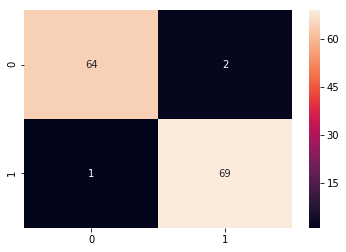

In [13]:
sns.heatmap(mat, annot=True)

In [14]:
fpr, tpr = fpr_tpr(mat)
print('FPR = {:.3f}, TPR = {:.3f}'.format(fpr, tpr))

FPR = 0.030, TPR = 0.986


In [15]:
importances = zip(results['importances'], results['genes'])

In [16]:
importances = sorted(importances, key = lambda x:x[0], reverse=True)


In [17]:
scores = list(map(lambda x:x[0], importances[:20]))
genes = list(map(lambda x:x[1], importances[:20]))

### Gene importance determined by RF classifier

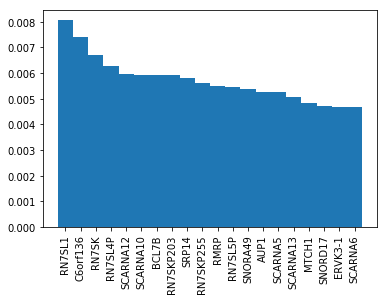

In [18]:
plt.bar(np.arange(len(scores)), scores, width=1)
plt.xticks(labels=genes, ticks=np.arange(len(scores)), rotation=90)
plt.show()
plt.close()

In [19]:
with open('/mnt/RiboVsPolyA/results/RF_gene_rank_run2.tsv', 'w') as f:
    f.write('Gene\tScore\n')
    for i in range(len(scores)):
        score = scores[i]
        gene = genes[i]
        f.write(gene+'\t'+str(score)+'\n')
        
    

### Attempting to improve probability threshold

Text(0.5, 1.0, 'Probability of being Ribo')

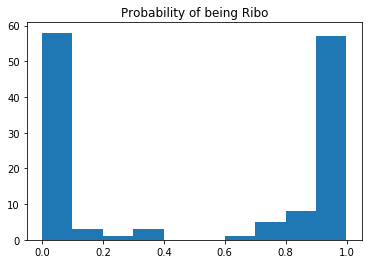

In [20]:
plt.hist(results['pred_proba'][:,1])
plt.title('Probability of being Ribo')

<Figure size 720x720 with 0 Axes>

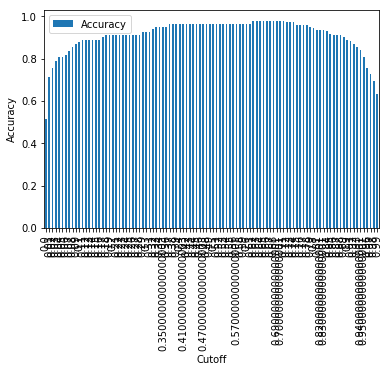

Best cutoff: 0.62
Best accuracy: 0.9789855942376952


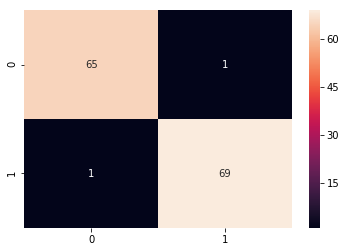

In [21]:
# optimize for negative label

accuracy_df=pd.DataFrame()
best_score=None
best_cutoff=None
best_pred=None
for cutoff in np.arange(0,1,0.01):

    test_pred_classes=[]
    for i in results['pred_proba'][:,1]:
        if i>=cutoff:
            test_pred_classes+=[1]
        else:
            test_pred_classes+=[0]
            
    score=average_precision_score(results['test_labels'],test_pred_classes )
    accuracy_df.loc[cutoff, 'Accuracy']=score
    #storing predictions with best accuracy score
    if best_score is None or score>best_score:
        best_score=score
        best_cutoff=cutoff
        best_pred=test_pred_classes


plt.figure(figsize=(10,10))
accuracy_df.plot(kind='bar')
plt.xlabel('Cutoff')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')

plt.show()
plt.close()
print('Best cutoff: {}'.format(best_cutoff))
print('Best accuracy: {}'.format(best_score))

# print(accuracy_df.describe())

mat_2 = confusion_matrix(results['test_labels'], best_pred)
sns.heatmap(mat_2, annot=True)

In [22]:
fpr, tpr = fpr_tpr(mat_2)
print('FPR = {:.3f}, TPR = {:.3f}'.format(fpr, tpr))

FPR = 0.015, TPR = 0.986


### After optimizing the cutoff:
* FPR dropped from 0.06 to 0.015
* TPR also dropped from 1 to 0.97
